# Sequence Final Project - Optimization

## First Approach to the Optimization Problem

### Requirements

In [1]:
from library import init_params
from pyomo.environ import *
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

### Parameters

In [2]:
# Décommenter la ligne que vous voulez utiliser pour l'instance
instance = "instances/toy_instance.json"
# instance = "instances/medium_instance.json" 
# instance = "instances/large_instance.json"
h,qualif_nb,staff_nb,project_nb,C,CA,N,G,D,R,names = init_params(instance)

### Solving function

In [ ]:
def solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R,epsilon):

    # --- 1. Model creation

    model = ConcreteModel()
    # Sets
    model.H = RangeSet(0,h-1)          # Planning Horizon
    model.S = RangeSet(0,staff_nb-1)        # Staff set
    model.P = RangeSet(0,project_nb-1)          # Projects set
    model.Q= RangeSet(0,qualif_nb-1)           # Qualifications set
        
    # Params
    
    model.h = Param(initialize=h)
    model.staff_nb = Param(initialize=staff_nb)
    model.qualif_nb = Param(initialize=qualif_nb)
    model.project_nb = Param(initialize=project_nb)

    # Variables
    
    model.w = Var(model.H, model.P, model.Q, model.S, within=Binary)
    model.y = Var(model.P,model.H,within=Binary)
    model.f = Var(model.P, within=Integers)
    model.z = Var(model.P, within=Binary)
    model.start = Var(model.P,within=Integers)
    model.duree = Var(model.P, within=NonNegativeIntegers)


    
    # Objective function
    
    def total_profit(model):
        profit = sum(
            model.z[p] * CA[p]
            for p in model.P)
        return profit

    model.obj = Objective(rule=total_profit, sense=maximize)
    
    # Constraints

    ## Constraint on the validation of the projects
    
    def validation_rule(model,p,q):
        return sum(model.w[t,p,q,s] for t in model.H for s in model.S) >= N[p,q] * model.z[p]
    model.validation = Constraint(model.P, model.Q, rule=validation_rule)
    def project_done_rule(model, p):
    # Supposons que T_max est la dernière date possible du planning
     return model.f[p] <= h * model.z[p]
    model.project_done = Constraint(model.P, rule=project_done_rule)

    def activation_rule(model, p, t):
        return model.y[p, t] <= sum(model.w[t, p, q, s] for s in model.S for q in model.Q)
    model.activation = Constraint(model.P, model.H, rule=activation_rule)
    def affectation_rule(model, p, t):
        M = len(model.S) * len(model.Q)
        return sum(model.w[t, p, q, s] for s in model.S for q in model.Q) <= M * model.y[p, t]
    model.affectation = Constraint(model.P, model.H, rule=affectation_rule)
    def ending_rule(model,p,t):
        return model.f[p] >= (t+1) * model.y[p, t]
    model.ending_rule = Constraint(model.P, model.H, rule=ending_rule)
    def start_inf_rule(model, p, t):
        return model.start[p] <= (t+1) + (1 - model.y[p, t]) * h
    model.start_inf = Constraint(model.P, model.H, rule=start_inf_rule)

    def start_sup_rule(model, p, t):
        return model.start[p] >= (t+1) * model.y[p, t]
    model.start_sup = Constraint(model.P, model.H, rule=start_sup_rule)
    ## Qualification constraint
    def qualification_rule(model,t,p,q,s):
        return  model.w[t, p, q, s] <= C[s, q]
    model.qualification = Constraint(model.H, model.P, model.Q, model.S, rule=qualification_rule)
    def duree_rule(model, p):
        return model.duree[p] == model.f[p] - model.start[p]
    model.duree_expr = Constraint(model.P, rule=duree_rule)
    def epsilon_duree_rule(model, p):
        return model.duree[p] <= epsilon
    model.epsilon_duree = Constraint(model.P, rule=epsilon_duree_rule)


    ## Day Off constraint
    def day_off_rule(model,t,s):
        return sum(model.w[t,p,q,s] for p in model.P for q in model.Q) <= G[s,t]
    model.day_off = Constraint(model.H, model.S, rule=day_off_rule)

    # --- 4. Solve
    
    # Nombre de variables
    num_var = len(list(model.component_data_objects(ctype=pyomo.environ.Var)))
    print("Nombre de variables :", num_var)

    # Nombre de paramètres
    num_param = len(list(model.component_data_objects(ctype=pyomo.environ.Param)))
    print("Nombre de paramètres :", num_param)

    # Nombre de contraintes
    num_constraint = len(list(model.component_data_objects(ctype=pyomo.environ.Constraint)))
    print("Nombre de contraintes :", num_constraint)
    
    start = time.time() 
    solver = SolverFactory("cbc")  # or 'gurobi' if licensed
    results = solver.solve(model, tee=True)
    end = time.time()
    comp = end-start
    
    # -- 8. Transform it into computable forms
   
    w_arr = np.zeros((h,project_nb,qualif_nb,staff_nb))
    for t in range(h):
        for p in range(project_nb):
            for q in range(qualif_nb):
                for s in range(staff_nb):
                     w_arr[t, p, q, s] = value(model.w[t, p, q, s])

    y_arr = np.zeros((project_nb))
    f_arr = np.zeros((project_nb))
    for p in range(project_nb):
        f_arr[p] = value(model.f[p])
    
    return value(model.obj),w_arr,y_arr,comp,num_var,num_param,num_constraint
    

In [8]:
epsilon = 4
obj,w_arr,y_arr,comp,num_var,num_param,num_constraint = solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R,epsilon)

ERROR: Rule failed when generating expression for Constraint epsilon_duree
with index 0: TypeError: solv_wf.<locals>.epsilon_duree_rule() missing 1
required positional argument: 'epsilon'
ERROR: Constructing component 'epsilon_duree' from data=None failed:
        TypeError: solv_wf.<locals>.epsilon_duree_rule() missing 1 required
        positional argument: 'epsilon'


TypeError: solv_wf.<locals>.epsilon_duree_rule() missing 1 required positional argument: 'epsilon'

## Visualisation of results

### Visualisation of planning

In [5]:
table = pd.DataFrame(index=names, columns=range(h))

alp = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for t in range(h):
    for p in range(project_nb):
        for q in range(qualif_nb):
            for s in range(staff_nb):
                if w_arr[t, p, q, s] == 1:
                    table.iloc[s,t] = f"Job {p} {alp[q]}"

# table : DataFrame avec les valeurs "P X Q Y" ou NaN
table_plot = table.fillna("Day Off")

print("Optimization cost :", obj)
print("Computation time (s) :", comp)

Optimization cost : 65.0
Computation time (s) : 0.23059844970703125


C:\Users\baptg\AppData\Local\Temp\ipykernel_25352\3948118595.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  project_table = table_plot.applymap(extract_project)
C:\Users\baptg\AppData\Local\Temp\ipykernel_25352\3948118595.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  int_table = project_table.replace(project_to_int).astype(int)


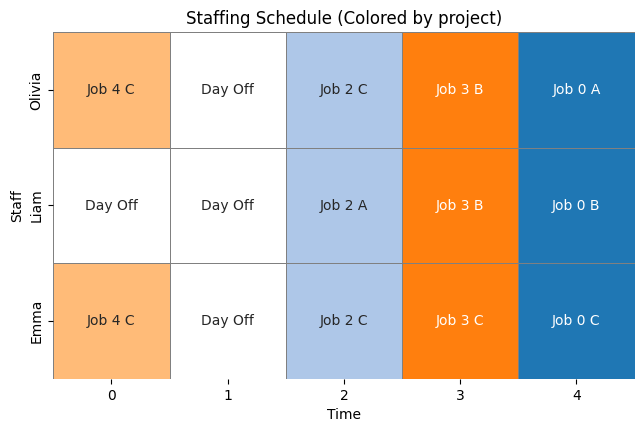

In [6]:
# Extraire uniquement les projets pour le mapping couleur
def extract_project(val):
    if val in ["", "Day Off"]:
        return "Day Off"
    return val.split()[1]  # "Proj X" → "X"

project_table = table_plot.applymap(extract_project)

# Liste des projets uniques (hors "Day Off")
unique_projects = sorted(list(set(v for v in project_table.values.flatten() if v not in ["", "Day Off"])))

# Mapping projet → entier pour heatmap
project_to_int = {"Day Off": 0}
project_to_int.update({v: i+1 for i, v in enumerate(unique_projects)})

int_table = project_table.replace(project_to_int).astype(int)

# Palette : blanc pour "Day Off", puis couleurs pour projets
palette = [(1,1,1)] + sns.color_palette("tab20", len(unique_projects))

# Plot
plt.figure(figsize=(h*1.5, staff_nb*1.5))
ax = sns.heatmap(int_table, annot=table_plot.values, fmt='',
                 cmap=palette,
                 cbar=False,
                 linewidths=0.5, linecolor='gray')

ax.set_xlabel("Time")
ax.set_ylabel("Staff")
ax.set_title("Staffing Schedule (Colored by project)")
plt.show()

In [47]:
obj

np.float64(82.0)